In [139]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sbn
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import os
print(os.listdir("../input"))
import pickle
# Any results you write to the current directory are saved as output.

['201807-fordgobike-tripdata.csv', '201801-fordgobike-tripdata.csv', '201808-fordgobike-tripdata.csv', '201806-fordgobike-tripdata.csv', '201809-fordgobike-tripdata.csv', '201804-fordgobike-tripdata.csv', '201802-fordgobike-tripdata.csv', '201805-fordgobike-tripdata.csv', '2017-fordgobike-tripdata.csv', '201803-fordgobike-tripdata.csv']


In [140]:
import pandas as pd
import numpy as np
import glob
import theano.tensor as T
import theano
from sklearn.metrics import mean_squared_error

In [141]:
print ("Helpful guide: https://github.com/parsing-science/pymc3_quickstart_guide")
df=pd.concat([pd.read_csv(f) for f in glob.glob('../input/*.csv')], ignore_index = True)
df.count()[0]

Helpful guide: https://github.com/parsing-science/pymc3_quickstart_guide


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


1916465

In [142]:
"""
Here are a few takeaways from the statistics of our dataset:

Gender Breakdown: 19% Female, 67% Male
Subscribers: 79% Subscribers

There are a number of missing values in a variety of columns in the dataset.
The duration of the rides generally look to be for less than an hour, but 
some values are anomalously high.


"""

df=df.dropna()
df.head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
0,1953,No,59989,181.0,37.811377,-122.265192,Grand Ave at Webster St,2018-08-01 11:00:22.1890,1995.0,Male,197.0,37.808848,-122.249680,El Embarcadero at Grand Ave,2018-07-31 18:20:32.7230,Customer
1,3010,No,60232,356.0,37.769188,-122.422285,Valencia St at Clinton Park,2018-08-01 10:08:18.7520,1994.0,Female,77.0,37.773507,-122.416040,11th St at Natoma St,2018-07-31 17:24:26.2350,Subscriber
3,1043,No,51522,345.0,37.766474,-122.398295,Hubbell St at 16th St,2018-08-01 09:13:06.6610,1990.0,Female,114.0,37.764478,-122.402570,Rhode Island St at 17th St,2018-07-31 18:54:23.7210,Subscriber
4,1336,No,83380,198.0,37.807813,-122.264496,Snow Park,2018-08-01 08:32:09.2700,1982.0,Male,213.0,37.823847,-122.281193,32nd St at Adeline St,2018-07-31 09:22:29.1000,Subscriber
5,697,No,49546,356.0,37.769188,-122.422285,Valencia St at Clinton Park,2018-08-01 08:29:57.8380,1991.0,Female,139.0,37.751017,-122.411901,Garfield Square (25th St at Harrison St),2018-07-31 18:44:11.5730,Customer


In [143]:
df["duration_hrs"]=df["duration_sec"]/3600.
df["age"]=2019-df["member_birth_year"]
df["start_day"]=pd.to_datetime(df["start_time"], errors='ignore')
df["start_day"]= df['start_day'].dt.floor("d")

In [144]:
df=pd.get_dummies(columns=["member_gender","user_type"],data=df)
df.head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,duration_hrs,age,start_day,member_gender_Female,member_gender_Male,member_gender_Other,user_type_Customer,user_type_Subscriber
0,1953,No,59989,181.0,37.811377,-122.265192,Grand Ave at Webster St,2018-08-01 11:00:22.1890,1995.0,197.0,37.808848,-122.249680,El Embarcadero at Grand Ave,2018-07-31 18:20:32.7230,16.663611,24.0,2018-07-31,0,1,0,1,0
1,3010,No,60232,356.0,37.769188,-122.422285,Valencia St at Clinton Park,2018-08-01 10:08:18.7520,1994.0,77.0,37.773507,-122.416040,11th St at Natoma St,2018-07-31 17:24:26.2350,16.731111,25.0,2018-07-31,1,0,0,0,1
3,1043,No,51522,345.0,37.766474,-122.398295,Hubbell St at 16th St,2018-08-01 09:13:06.6610,1990.0,114.0,37.764478,-122.402570,Rhode Island St at 17th St,2018-07-31 18:54:23.7210,14.311667,29.0,2018-07-31,1,0,0,0,1
4,1336,No,83380,198.0,37.807813,-122.264496,Snow Park,2018-08-01 08:32:09.2700,1982.0,213.0,37.823847,-122.281193,32nd St at Adeline St,2018-07-31 09:22:29.1000,23.161111,37.0,2018-07-31,0,1,0,0,1
5,697,No,49546,356.0,37.769188,-122.422285,Valencia St at Clinton Park,2018-08-01 08:29:57.8380,1991.0,139.0,37.751017,-122.411901,Garfield Square (25th St at Harrison St),2018-07-31 18:44:11.5730,13.762778,28.0,2018-07-31,1,0,0,1,0


In [145]:
aggregations = {
    'duration_hrs':'mean',
    "age" :"mean",
    "member_gender_Female":"sum",
    "member_gender_Male":"sum",
    "member_gender_Other":"sum",
    "user_type_Customer":"sum",
    "user_type_Subscriber":"sum",  
}
day=df.groupby("start_day").agg(aggregations)
day.head()

,duration_hrs,age,member_gender_Female,member_gender_Male,member_gender_Other,user_type_Customer,user_type_Subscriber
start_day,,,,,,,
2018-01-01,0.327328,37.226784,327.0,673.0,23,243.0,780.0
2018-01-02,0.190775,38.804370,700.0,2239.0,36,160.0,2815.0
2018-01-03,0.199503,38.427566,621.0,2033.0,45,133.0,2566.0
2018-01-04,0.184618,38.391526,699.0,2400.0,40,171.0,2968.0
2018-01-05,0.179397,38.188603,424.0,1530.0,29,104.0,1879.0


In [146]:
day["total_riders"]=day["user_type_Customer"]+day["user_type_Subscriber"]

In [147]:
print (len(day["total_riders"]))
nextDay=list(day["total_riders"])
nextDay.pop(0)#Don't need this value anymore
nextDay.append(0.0)#Add a zero to the next one as a test
print (len(nextDay))
#print (nextDay)

273
273


In [148]:
day["nextDay"]=nextDay
day=day[:len(nextDay)-1]
day.head(5)


,duration_hrs,age,member_gender_Female,member_gender_Male,member_gender_Other,user_type_Customer,user_type_Subscriber,total_riders,nextDay
start_day,,,,,,,,,
2018-01-01,0.327328,37.226784,327.0,673.0,23,243.0,780.0,1023.0,2975.0
2018-01-02,0.190775,38.804370,700.0,2239.0,36,160.0,2815.0,2975.0,2699.0
2018-01-03,0.199503,38.427566,621.0,2033.0,45,133.0,2566.0,2699.0,3139.0
2018-01-04,0.184618,38.391526,699.0,2400.0,40,171.0,2968.0,3139.0,1983.0
2018-01-05,0.179397,38.188603,424.0,1530.0,29,104.0,1879.0,1983.0,1554.0


In [149]:
from sklearn.preprocessing import RobustScaler
scaledDF = RobustScaler().fit_transform(day)
scaledDF = pd.DataFrame(data=scaledDF, columns = ["scaled_"+str(x) for x in day.columns])

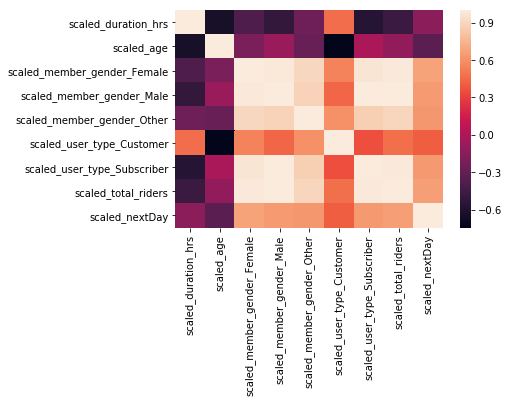

In [150]:
"""
From the heatmap, we can see some simple relationships between variabes, 
both positive and negative with respect to our target variable (nextDay).

However, this only tells part of the story. We know that the variables 
are inter-related, and to corresponding to some magnitude of correlation,
but there could be deeper relationships as well.
"""
corr = scaledDF.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

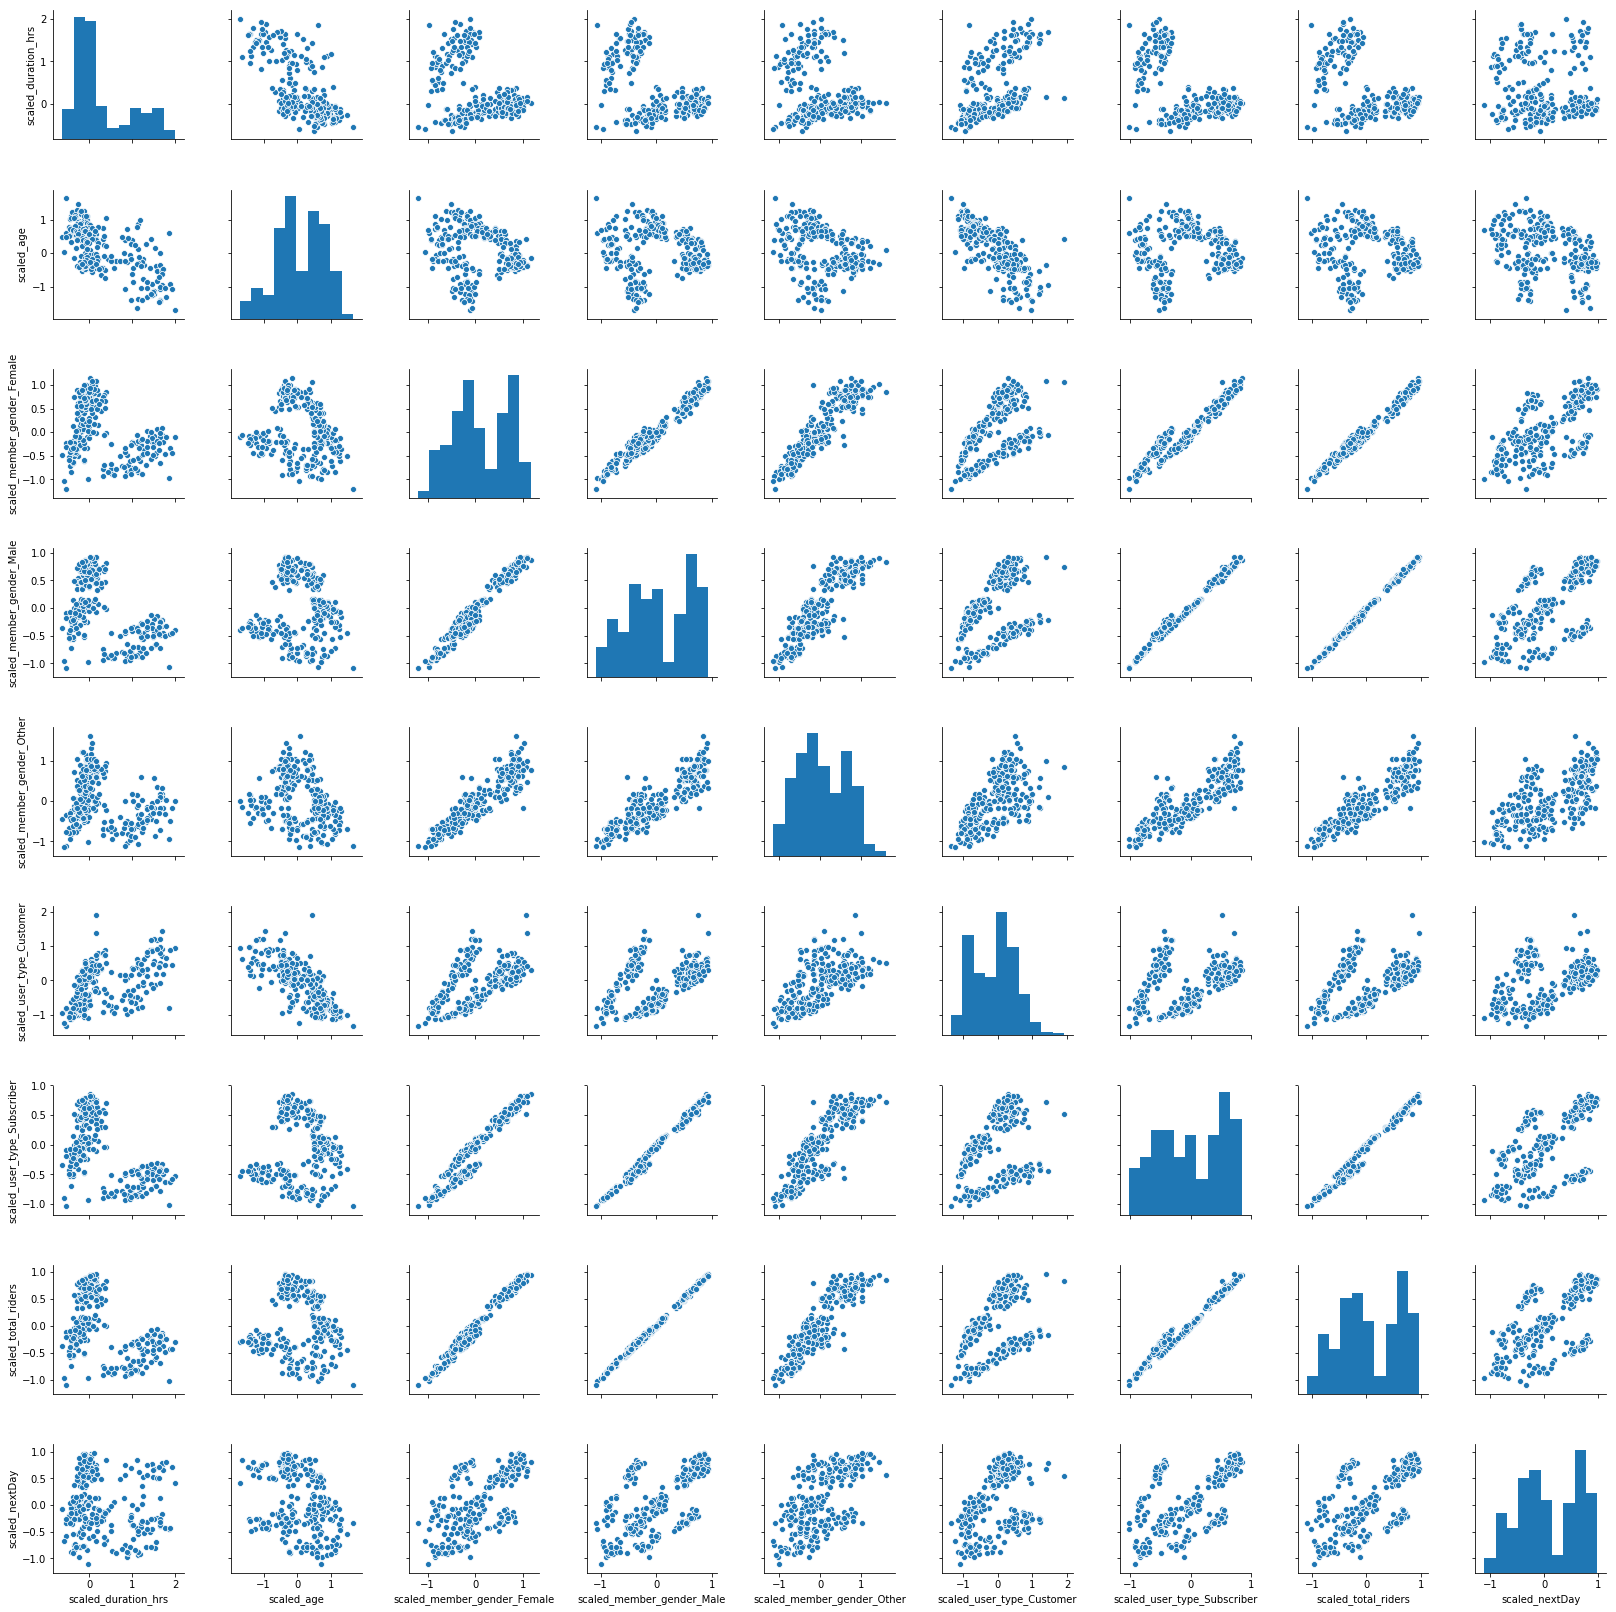

In [151]:
"""
If we plot the distributions of these variables, we see 
significant co-linearity among some variables with respect 
to the next day predictions. Predictably, categorical features
that exist in the majority (male ridership and subscription riders)
have strong relationships.

Our target value (next day's ridership) appears to be a binomial distribution. Many
of the features, when scaled, also share this type of distribution. The scatter plots
show that there exist multiple linear relationships for some of the features. These could
correspond to weekend/weekday differences.
"""
g = sbn.pairplot(scaledDF);

In [152]:
import theano.tensor as T

y = scaledDF["scaled_nextDay"]
X = scaledDF.drop('scaled_nextDay',axis=1)

#Let's test our model on the last month of data
month_split = len(y)-30
X_train , Y_train =  X[:month_split], y[:month_split]
X_test , Y_test = X[month_split:], y[month_split:]

#We initiate a shared theano array for training and
#    testing splits for ease of use.
model_input = theano.shared(np.array(X_train))
model_output = theano.shared(np.array(Y_train))

In [153]:
"""
What would a general sklearn Linear Regression pick for our parameters,
and how would it score? We can use this as our ML baseline without 
any hyperparameter tuning.
"""

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,Y_train)
preds = lr.predict(X_test)
np.sqrt(mean_squared_error(Y_test, preds))

0.4144044173755133

In [154]:
print (lr.coef_)
print (lr.intercept_)

[ 0.31053446 -0.33824114  0.03395852  0.38799373 -0.04163156 -0.42391064
  0.35416055  0.29422238]
-0.056938651272233215


In [155]:
import pymc3 as pm

print('Running on PyMC3 v{}'.format(pm.__version__))

big_model = pm.Model()

with big_model:
    """
    Our simple, linear model requires an intercept (alpha) and a weight
    for each of our parameters (beta). I have no prior knowledge about what
    the weights could be, but I know the features are scaled by the 
    RobustScaler. Therefore, we can assume they might be of centered around
    0 (mu). In this example, we did not choose to scale our target value 
    (riders the next day), so the slope of our scaled parameters might be 
    quite large. Therefore, we set sd=100. If we set it too low, it may 
    never find the correct beta value for that parameter.
    """
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100, shape=8)
    sigma = pm.Normal("sigma",mu=0, sd=100)
    """
    The values we are trying to predict will be a simple dot product of our 
    features with the weights of our model (transpose of beta) plus our 
    intercept. We take the exponential of this value because we will 
    be modelling our output as a Poisson distribution. If we modeled it
    as a Gaussian, we would remove the np.exp and introduce a value 
    for the noise (sigma).
    """ 
    values = alpha + T.dot(model_input, beta.T) 
    
    """
    This is the final output of our model. Our target variable (model_output)
    is being modelled as a Poisson, as we are dealing with a simple counting
    statistic (the number of riders the next day). We could reasonably choose
    a different distribution in PyMC3 (Normal, DiscreteUniform, et al.) but 
    this seems intuitive.
    """
    Y_obs = pm.Normal('Y_obs', mu=values, sd=sigma, observed=model_output)

Running on PyMC3 v3.6


In [156]:
"""
What if we have a large, complicated model that we can only
approximate the posterior distribution?  Use Variational Inference:
https://docs.pymc.io/api/inference.html?highlight=advi#pymc3.variational.inference.ADVI

It works extremely quickly compared to NUTS, and can offer increased performance in 
estimating the model parameters for very complex distributions. Simple distributions 
will be better fit by NUTS.
"""
with big_model:
    inference = pm.ADVI()
    approx = pm.fit(n=80000, method=inference)

Average Loss = 185.98: 100%|██████████| 80000/80000 [00:51<00:00, 1565.65it/s]   
Finished [100%]: Average Loss = 185.99


In [157]:
#Now we sample from our approximation in order to get a similar trace
advi_trace = approx.sample(10000)

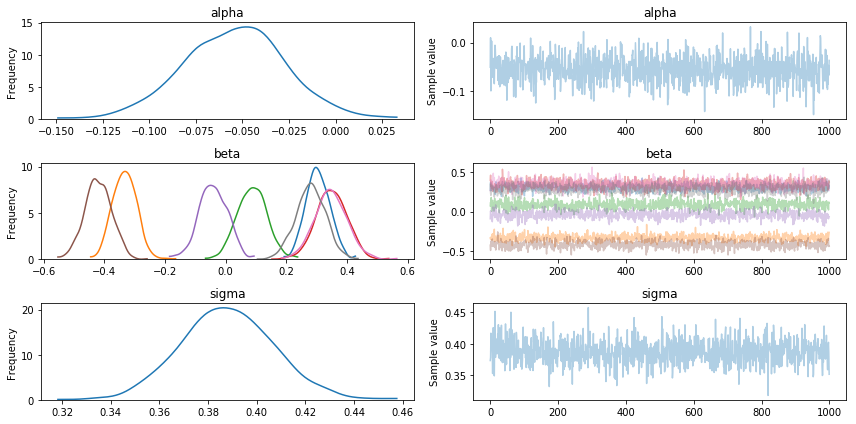

In [158]:
pm.traceplot(advi_trace[-1000:]);

In [159]:
pm.summary(advi_trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.054811,0.027015,0.000750,-0.111727,-0.005304
beta__0,0.303633,0.039006,0.001221,0.227859,0.377598
beta__1,-0.333313,0.038986,0.001152,-0.404052,-0.257818
beta__2,0.086582,0.048599,0.001471,-0.008760,0.178983
beta__3,0.347955,0.050891,0.001772,0.248154,0.442344
beta__4,-0.041690,0.046833,0.001600,-0.133538,0.046532
beta__5,-0.420941,0.043897,0.001460,-0.500011,-0.332021
beta__6,0.345858,0.053305,0.001534,0.244326,0.454376
beta__7,0.279191,0.048256,0.001481,0.183653,0.371684
sigma,0.387671,0.018862,0.000544,0.350256,0.423954


In [160]:
#Save the advi model as well
fileObject = open("advi_trace.pickle",'wb')  
pickle.dump(advi_trace, fileObject)
fileObject.close()

In [162]:
"""
Let's get the RMSE of our model as understood by the NUTS and ADVI
sampler. We will test our training data error first.

The NUTS sampler does a pretty decent job on predictions, and has a 
better RMSE than our sklearn LR model.
"""

def scoreModel(trace,y,model_name):
    ppc = pm.sample_ppc(trace[:2000], model=model_name, samples=1000)
    pred = ppc['Y_obs'].mean(axis=0)
    return np.sqrt(mean_squared_error(y, pred))

scoreModel(advi_trace,Y_train,big_model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 1000/1000 [00:13<00:00, 73.65it/s]


0.37658236122240424

In [ ]:
"""
Now we simply switch out our Theano tensor with our 
testing data. Using the shared value, we do not have
to respecify our model first.
"""
model_input.set_value(np.array(X_test))
model_output.set_value(np.array(Y_test))

scoreModel(advi_trace,Y_test,big_model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  # Remove the CWD from sys.path while we load stuff.
  3%|▎         | 29/1000 [00:00<00:24, 39.02it/s]

In [ ]:
"""
Once again, our PyMC3 models do better than our sklearn 
model, and we did not do any hyperparameter tuning for either.

Is the increased difficulty and time worth the better performance? 
That is for you to decide.
"""
scoreModel(advi_trace,Y_test,big_model)

One important thing to note here is that we do not have a single set of weights for our model, but a distribution of weights. From this we can make informed decisions about any predictions we have, building confidence regions around each predicted point. Although sklearn is much easier in building a model, PyMC3 offers much greater control on how the model is built and trained.